<a href="https://colab.research.google.com/github/srimanthtenneti/DCGANs/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets , transforms
from torch.utils.data import DataLoader

In [73]:
transform = transforms.ToTensor()
trainset = datasets.SVHN('./root' , split = 'train' , download = True , transform=transform)

Using downloaded and verified file: ./root/train_32x32.mat


In [74]:
batch_size = 64
trainloader = DataLoader(dataset=trainset , batch_size = batch_size , shuffle= True)

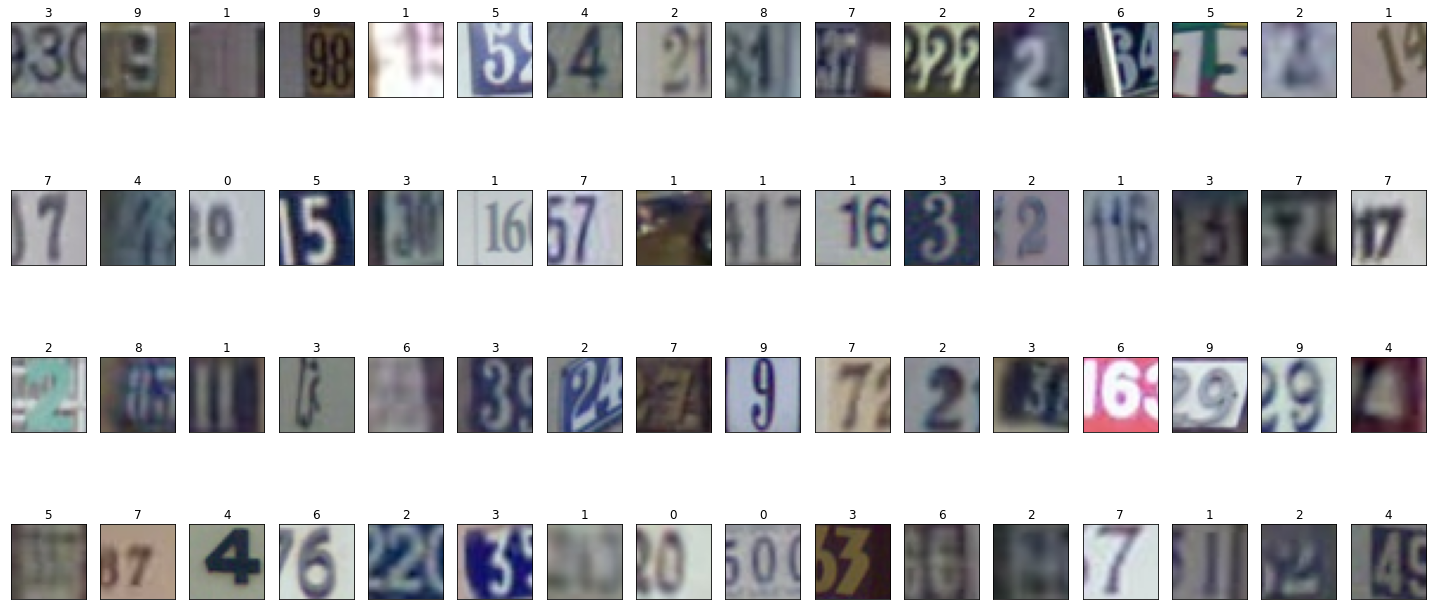

In [75]:
images , labels = iter(trainloader).next()
images , labels = images.numpy() , labels.numpy()

figure = plt.figure(figsize=(20,10))

for i in range(batch_size):
  ax = figure.add_subplot(4 , batch_size/4 , i+1 , xticks = [] , yticks = [])
  ax.imshow(images[i].transpose(1,2,0).squeeze())
  ax.set_title(labels[i])

plt.tight_layout()

In [76]:
img = images[0]
print("Min value of the image is :",img.min())
print()
print("Max value of the image is :",img.max())

Min value of the image is : 0.09411765

Max value of the image is : 0.6


In [77]:
def scale(x , feature_range = (-1 , 1)):
  min , max = feature_range
  x = x * (max - min) + min
  return x

In [78]:
scaled_img = scale(img)
print("Min value of the image is :",scaled_img.min())
print()
print("Max value of the image is :",scaled_img.max())

Min value of the image is : -0.8117647

Max value of the image is : 0.20000005


In [79]:
print("Shape of image is : ",scaled_img.shape)

Shape of image is :  (3, 32, 32)


In [90]:
#**************************************
#      Discriminator Network
#**************************************

class Discriminator(nn.Module):
  def __init__(self , conv_dim = 64):
    super(Discriminator , self).__init__()
    # Defining parameters
    self.conv_dim = conv_dim
    # Defining the layers
    self.conv1 = nn.Conv2d(3 , conv_dim , 4  , stride = 2 , padding = 1 , bias = False)
    self.conv2 = nn.Conv2d(conv_dim , conv_dim*2 , 4 , stride = 2 , padding = 1 , bias = False)
    self.batn1 = nn.BatchNorm2d(conv_dim*2)
    self.conv3 = nn.Conv2d(conv_dim*2 , conv_dim*4 , 4 ,  stride=2 , padding=1 , bias = False) 
    self.batn2 = nn.BatchNorm2d(conv_dim*4)
    self.drop  = nn.Dropout(0.3)
    self.fcly1 = nn.Linear(conv_dim*4*4*4 , 1)

  def forward(self , out):
    out = F.leaky_relu(self.conv1(out) , 0.2)
    out = self.batn1(F.leaky_relu(self.conv2(out) , 0.2))
    out = self.batn2(F.leaky_relu(self.conv3(out) , 0.2))

    out = out.view(-1 , self.conv_dim*4*4*4)
    
    out = self.fcly1(out)
    out = self.drop(out)

    return out
    

In [91]:
#**************************************************
#           Generator Network
#**************************************************
class Generator(nn.Module):
  def __init__(self , z_size , conv_dim = 64):
    super(Generator , self).__init__()
    # Defining parameters
    self.conv_dim = conv_dim
    self.z_size = z_size
    # Defining the layers
    self.fcly1 = nn.Linear(z_size , conv_dim*4*4*4)
    self.drop  = nn.Dropout(0.3)
    self.tcnv1 = nn.ConvTranspose2d(conv_dim*4 , conv_dim*2 , 4 , padding=1 , stride=2 , bias = False)
    self.batn1 = nn.BatchNorm2d(conv_dim*2)
    self.tcnv2 = nn.ConvTranspose2d(conv_dim*2 , conv_dim , 4,padding=1 , stride=2 , bias = False)
    self.batn2 = nn.BatchNorm2d(conv_dim)
    self.tcnv3 = nn.ConvTranspose2d(conv_dim , 3 , 4,padding=1 , stride=2 , bias = False)

  def forward(self , out):
    out = self.fcly1(out)
    out = self.drop(out)
    out = out.view(-1 , self.conv_dim*4 , 4 , 4)
    out = self.batn1(F.relu(self.tcnv1(out)))
    out = self.batn2(F.relu(self.tcnv2(out)))
    out = F.tanh(self.tcnv3(out))
    return out


In [92]:
conv_dim = 64
z_size = 128

D = Discriminator(conv_dim)
G = Generator(z_size=z_size , conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fcly1): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fcly1): Linear(in_features=128, out_features=4096, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (tcnv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tcnv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batn2): BatchNor

In [93]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


In [94]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [101]:
import torch.optim as optim

# params
lr = 0.0003

beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [102]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(trainloader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 0.4905 | g_loss: 8.6245
Epoch [    1/   50] | d_loss: 0.4464 | g_loss: 6.2141
Epoch [    1/   50] | d_loss: 0.4454 | g_loss: 5.0716
Epoch [    1/   50] | d_loss: 0.4598 | g_loss: 5.4884
Epoch [    2/   50] | d_loss: 0.4165 | g_loss: 7.1769
Epoch [    2/   50] | d_loss: 0.4493 | g_loss: 4.8821
Epoch [    2/   50] | d_loss: 0.3908 | g_loss: 6.9812
Epoch [    2/   50] | d_loss: 0.4231 | g_loss: 5.9495
Epoch [    3/   50] | d_loss: 0.4238 | g_loss: 5.0826
Epoch [    3/   50] | d_loss: 0.4129 | g_loss: 6.4327
Epoch [    3/   50] | d_loss: 0.4567 | g_loss: 6.6511
Epoch [    3/   50] | d_loss: 0.4225 | g_loss: 4.6705
Epoch [    4/   50] | d_loss: 0.4678 | g_loss: 6.8616
Epoch [    4/   50] | d_loss: 0.4359 | g_loss: 5.7257
Epoch [    4/   50] | d_loss: 0.3967 | g_loss: 6.1800
Epoch [    4/   50] | d_loss: 0.4158 | g_loss: 9.1265
Epoch [    5/   50] | d_loss: 0.4124 | g_loss: 6.4272
Epoch [    5/   50] | d_loss: 0.4476 | g_loss: 7.1997
Epoch [    5/   50] | d_loss

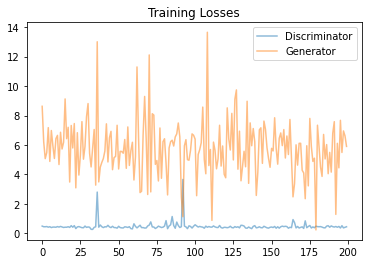

In [103]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [104]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

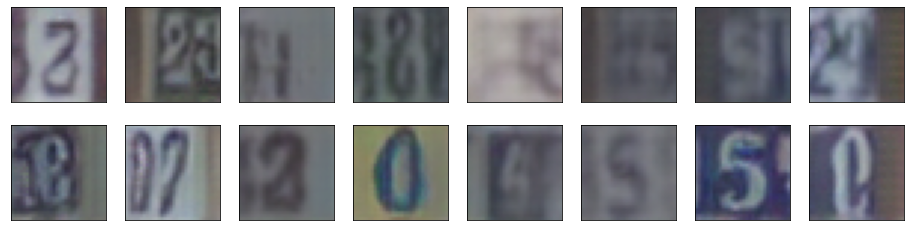

In [105]:
_ = view_samples(-1, samples)